# **Trabalho 2: Disciplina Machine Learning. DCC-UFMG**

## **Aluno:** Gustavo Henrique Pereira Godinho

O objetivo desse trabalho prático é ganhar experiência com o processo de Boosting. Aqui será implementado o processo de Boosting visto em sala de aula, o algoritmo **Adaboost** para um problema de classificação binária com atributos categóricos. O dataset utilizado será o *tic-tac-toe*, disponível em https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame. Esse dataset contém vários jogos da velha e o objetivo é estimar quando o jogador que joga com 'x' vence.

### **Implementação do algoritmo**

O primeiro passo é importar os pacotes necessários para implementar as funções do **Adaboost**. Eles são: o *pandas* que serve para manipular dataframes e vai ser muito útil para as funções que serão usadas, o *math* e *numpy* que são os pacotes básicos de matemática e manipulação algébrica do python, respectivamente. O *matplotlib* para fazer gráficos e do sklearn eu vou usar a função para fazer a validação cruzada.


In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

A primeira função é a **calcula_erros**. O objetivo dessa função é calcular a soma dos pesos das observações presentes nos dados onde determinada *decision stump* errou. Essa função é fundamental para avaliar qual será a variável que estará na *decision stump* de cada iteração.

In [3]:
def calcula_erros(X, stump, y, classe_positiva, pesos, valor = None, retornar_observacoes = False):
#""" Argumentos:
#  @ X: dataframe com as covariáveis.
#  @ stump: string com o nome da covariável que servirá para a decision stump decidir ou não se a 
#           observação tem predição positiva ou predição negativa.
#  @ y: dataframe com uma coluna ou pandas.series com a variável resposta (variável alvo). 
#  @ classe_positiva: string com o nome da classe positiva da variável resposta (variável alvo).
#  @ pesos: lista ou pandas.series com os pesos das observações do conjunto de dados.
#  @ valor: valor que a covariável da stump assume. Lembrando do exemplo visto em aula do Vampiro, 
#           essa variável assumiria valores 'Y' ou 'N'. Aqui ela funcionará com uma pequena modificação.
#  @ retornar_observacoes: Esse argumento se verdadeiro retorna uma lista booleana com True nas posições 
#                          onde a decision_stump errou a predição.
#--------------------------------------------------------------------------------------------------
# Explicação funcionamento da função:
#  @ A estrutura condicional no início da função serve para conseguirmos considerar as stumps que estimam
#    todas as observações na classe positiva ou todas as observações na classe negativa. No estado else há
#    a o cálculo dos erros para uma stump sendo variável.
#  @ A variável erros_predicao_stump será uma lista com valores booleanos, onde as posições dessa lista serão iguais 
#    a True nas observações que a stump fez previsões errados.
#  @ A variável erro será uma soma ponderada pelos pesos da lista com valores booleanos (erros_predicao_stump). 
#    Lembrando que a multiplicação dos pesos pelas predições certas da stump será igual a 0, pois multiplicação 
#    de float por booleano False é igual a 0. Logo essa variável guardará apenas a soma das previsões erradas 
#    da stump.
#  @ A última condicional se refere apenas ao retorno da função. A variável usada na stump e o valor também usado 
#    na stump sempre estarão no retorno, assim como a soma ponderada dos erros. A diferença é o retorno ou não da
#    lista com valores booleanos com True nas posições das observações com previsão errada na stump. 
#"""

  if stump == True:
    erros_predicao_stump = (y != classe_positiva)
  elif stump == False:
    erros_predicao_stump = (y == classe_positiva)
  else:
    erros_predicao_stump = ((X[stump] == valor) != (y == classe_positiva))

  erro = sum([x*y for x, y in zip(erros_predicao_stump.to_list(), pesos.to_list())])

  if retornar_observacoes:
    return {'var': stump, 'val': valor, 'erro_stump': erro, 'mal_classificadas': erros_predicao_stump.to_list()}   
  else:
    return pd.DataFrame({'var': stump, 'val': valor, 'erro_stump': erro}, index = [0])

A função **atualiza_pesos** faz justamente o que o nome diz. Para as observações onde a previsão da stump está errada, é necessário aumentar o peso dessas observações para que seja mais improvável que elas estejam entre as previsões erradas na próxima iteração. A fórmula para mudança dos pesos para observaçções erradas é dada por: $$p_{j, i+1} = p_{j, i} + exp\{\alpha\}$$

e para observações corretas é dada por: $$p_{j, i+1} = p_{j, i} + exp\{-\alpha\}$$

Onde $p_{i, j}$ é o peso da observação $j$ na iteração $i$.



In [4]:
def atualiza_pesos(ind_erro, peso_atual, alpha):
#"""
#Argumentos:
#  @ ind_erro: indicação de erro na observação. Se True então quer dizer que a observação foi classificada de forma incorreta.
#  @ peso_atual: peso atual da observação.
#  @ alpha: valor do parâmetro alfa que servirá para ponderar a decision_stump e que também serve para atualizar os pesos das observações.
#--------------------------------------------------------------------------------------------------
#Explicação funcionamento da função:
#  @ A estrutura condicional retorna o novo peso para uma observação do conjunto de dados. Quando a previsão da classe foi feita de maneira 
#    incorreta pela decision_stump, o valor de retorno será maior que o peso atual já que alpha é positivo. Quando a previsão da classe foi
#    feita de maneira correta pela decision_stump, o valor de retorno será menor que o peso atual, já que será multiplicado pela exponencial
#    de um número negativo. 
#"""
  if ind_erro:
    return peso_atual * math.e**alpha 
  else:
    return peso_atual * math.e**(-alpha)

A função **corrigindo_nomes_stumps** é apenas uma função auxiliar para corrigir o retorno da decision_stump. É apenas uma função auxiliar que serve para formatar melhor a saída das stumps. Não interfere para o funcionamento do algoritmo. 

In [5]:
def corrigindo_nomes_stumps(df):
#"""
#Argumentos:
#  @ df: dataframe de uma linha que é exatamente a saída da função calcula_pesos.
#--------------------------------------------------------------------------------------------------
#Explicação funcionamento da função:
#  @ Essa função só adiciona duas colunas a saída da função calcula_pesos. Se a stump é uma das covariáveis,
#    então é necessário separar a variável do valor já que fazemos a matriz de covariáveis passar por um 
#    processo de virar variáveis 'dummies' no início da função de ajuste do algoritmo Adaboost. Se a decision
#    stump não é uma covariável e é do tipo: todas as previsões geradas pela stump como positiva ou negativa,
#    então não precisamos mudar o nome da variável e o valor presente na decision stump. 
#"""
  ind = df.index[0]
  if isinstance(df['var'][ind], str):
    obj = df['var'][ind].split('_')
    df1 = pd.DataFrame({'variavel': obj[0], 'valor': obj[1]}, index = [ind])
  else:
    df1 = pd.DataFrame({'variavel': df['var'][ind], 'valor': df['val'][ind]}, index = [ind])  

  return pd.concat([df, df1], axis = 1)


A função **executa_adaboost** é a principal para implementação do algoritmo. Essa função usa dos dados de entrada para a cada iteração achar a *decision_stump* que minimiza a soma dos pesos das observações erradas e a partir disso, calcula o $\alpha$ da iteração e atualiza os pesos das observações para seguir para a próxima.

In [6]:
def executa_adaboost(X, y, classe_positiva, num_iteracoes):
#"""
#Argumentos:
#  @ X: dataframe com as covariáveis.
#  @ y: dataframe com uma coluna ou pandas.series com a variável resposta (variável alvo). 
#  @ classe_positiva: string com o nome da classe positiva da variável resposta (variável alvo).
#  @ num_iteracoes: número inteiro com o número de iterações que o Adaboost irá executar.
#--------------------------------------------------------------------------------------------------
#Explicação funcionamento da função:
#  @ O primeiro passo dessa função é modificar o dataframe de covariáveis X o expandindo para criar
#    as variáveis dummies. Todas as covariáveis armazenadas em X terão valores 0 ou 1 depois disso.
#    O segundo passo é a criação da lista que guardará todas as stumps possíveis para o problema, essa
#    lista será guardada no objeto total_stumps. Também é criado objetos para guardar informações 
#    importantes de cada uma das iterações, como os pesos das observações, qual stump foi escolhida a 
#    cada iteração e os pesos de cada uma das hipóteses fracas (alphas).
#  @ A primeira estrutura condicional é apenas para evitar da função retornar um erro se for colocada
#    um número de iterações não-positivo.
#  @ Dado que o número de iterações é positivo, então há um loop nessas iterações.
#    @ Dentro do loop de uma iteração, o primeiro passo é criar uma lista que guardará os resultados da
#      iteração.
#    @ Após isso, entramos em outro loop que para todas as stumps possíveis para os dados, calcula a soma
#      ponderada dos erros com os respectivos pesos das iterações.
#    @ No objeto tbl_resultados é criado um dataframe a partir dos resultados dos erros das stumps na 
#      iteração. Nesse dataframe as stumps estão ordenadas pela ordem crescente dos erros e também é feito
#      um filtro para selecionar apenas as stumps que obtiveram soma dos pesos maior que zero. (Se a soma 
#      dos pesos da stump escolhida é igual a zero, então o alpha fica indeterminado e o algoritmo dá erro).
#    @ A stump com o menor erro positivo é salva em tbl_stumps e é assumida como a stump escolhida para 
#      aquela iteração. Daí é calculada o alpha da iteração e daí atualizado os pesos das observações para 
#      a próxima iteração.  
#  @ Ao sair do loop das iterações é concatenado os resultados e o retorno da função é um dicionário com 
#    duas tabelas: a primeira delas com detalhes de cada uma das stumps nas iterações e a segunda com os 
#    pesos de cada uma das observações ao longo das iterações.  
#"""    
  X = pd.get_dummies(X)
  total_stumps = [(x, y) for x in X.columns for y in [1]] + [(True, None), (False, None)]

  tbl_pesos = pd.DataFrame([1/X.shape[0]] * X.shape[0])
  tbl_stumps = []
  lst_alpha = []

  if num_iteracoes <= 0:
    print("Defina um número positivo de iterações.")
    return None
  else:
    for i in range(num_iteracoes):
      resultados = []
      for item in total_stumps:
        resultados.append(calcula_erros(X = X, stump = item[0], valor = item[1], y = y, 
                                        classe_positiva = classe_positiva, pesos = tbl_pesos.iloc[:, -1]))

      tbl_resultados = pd.concat(resultados).\
          sort_values(by = 'erro_stump', axis = 0, ascending = True).\
              query("erro_stump > 0")
        
      tbl_stumps.append(tbl_resultados.iloc[[0]])
      alpha_iteracao = math.log((1-min(tbl_resultados['erro_stump']))/min(tbl_resultados['erro_stump']))/2

      calculo_stump_escolhida = calcula_erros(X = X, stump = pd.concat(tbl_stumps)['var'].iloc[-1], valor = pd.concat(tbl_stumps)['val'].iloc[-1], 
                                              y = y, classe_positiva = classe_positiva, pesos = tbl_pesos.iloc[:, -1], retornar_observacoes = True)
      
      novos_pesos = [atualiza_pesos(ind_erro = item[0], peso_atual = item[1], alpha = alpha_iteracao) for item in list(zip(calculo_stump_escolhida['mal_classificadas'], tbl_pesos.iloc[:, -1].to_list()))]
      novos_pesos = list(map(lambda x: x/sum(novos_pesos), novos_pesos))

      tbl_pesos = pd.concat([tbl_pesos, pd.DataFrame(novos_pesos)], axis = 1)
      lst_alpha.append(alpha_iteracao)

    tbl_pesos.columns = ['iter_' + str(i) for i in range(tbl_pesos.shape[1])]
    tbl_pesos = tbl_pesos.iloc[:, :-1]
    tbl_stumps = pd.concat(tbl_stumps)
    tbl_stumps.index = range(tbl_stumps.shape[0])
    tbl_stumps['alpha'] = lst_alpha
    
    tbl_stumps = pd.concat([corrigindo_nomes_stumps(tbl_stumps.iloc[[i]]) for i in range(tbl_stumps.shape[0])], axis = 0).drop(['var', 'val'], axis = 1)

    return {'stumps': tbl_stumps, 'pesos': tbl_pesos}


As três próximas funções são necessárias para a predição de novos casos. Para fazer isso é necessário fazer a soma ponderada pelos $\alpha's$ das hipóteses fracas (stumps) e no final verificar o sinal dessa soma.

A primeira das funções é a **calcula_sinal** se o valor booleano for True, se retorna 1, se for False então retornamos -1.

In [7]:
def calcula_sinal(valor_booleano):
  if valor_booleano:
    return 1
  else:
    return -1

A próxima função **predicao_valor** calcula para uma nova observação qual seria a estimativa desse ponto em cada uma das stumps estimadas e daí faz a soma ponderada desses classificadores fracos pelos pesoas $\alpha$ associados a esses classificadores.

In [8]:
def predicao_valor(novo_x, stumps):
#"""
#Argumentos:
#  @ novo_x: dataframe de uma linha com as covariáveis.
#  @ stumps: dataframe com as stumps estimadas no treinamento do modelo.
#--------------------------------------------------------------------------------------------------
#Explicação funcionamento da função:
#  @ O primeiro passo dessa função é criar uma lista para guardar as predições de cada um 
#    dos classificadores fracos.
#  @ Daí para cada decision stump feita nas iterações do algoritmo, é calculada a previsão 
#    de em qual classe a observação fica. Se True, então a observação é estimada como classe
#    positiva, Se False então a observação é estimada na classe negativa.
#  @ O retorno dessa função é um valor real (positivo ou negativo) que é fruto da soma 
#    ponderada das estimativas de cada um dos classificadores fracos pelos correspondentes 
#    alfas associados.
#"""  
  predicoes = []
  for item in range(stumps.shape[0]):
    if isinstance(stumps['variavel'][item], str):
      predicoes.append( novo_x[stumps['variavel'][item]].iloc[0] == stumps['valor'][item])
    elif stumps['variavel'][item] == True :
      predicoes.append(True)
    else:
      predicoes.append(False)

  return sum([x*y for x, y in zip([calcula_sinal(i) for i in predicoes], stumps['alpha'])])

A função **predicao_classe** recebe o valor da soma ponderada da última função e se maior que 0 estima na classe positiva, se negativo faz a estimação do Adaboost para a observação na classe negativa.

In [9]:
def predicao_classe(valor, classes):
#"""
#Argumentos:
#  @ valor: float com o valor da soma ponderada dos classificadores fracos e seus respectivos alphas
#  @ classes: dicionario com o nome da classe positiva e classe negativa do problema em questão. 
#--------------------------------------------------------------------------------------------------
#Explicação funcionamento da função:
#  @ Se o valor da soma ponderada é maior ou igual a 0 então a observação é classificada na classe positiva.
#    Se o valor da soma ponderada é menor que 0 então a observação é classficada na classe negativa.
#"""  
  if valor >= 0:
    return classes['classe_positiva']
  else:
    return classes['classe_negativa']

Já a função **predicao_probs** recebe os mesmos argumentos que a função **predicao_classe** e daí usa os valores das somas dos pesos $\alpha's$ para calcular uma estimativa feita por mim de probabilidade da observação estar em cada uma das classes.


In [10]:
def predicao_probs(novo_x, stumps):
#"""
#Argumentos:
#  @ valor: float com o valor da soma ponderada dos classificadores fracos e seus respectivos alphas
#  @ classes: dicionario com o nome da classe positiva e classe negativa do problema em questão. 
#--------------------------------------------------------------------------------------------------
#Explicação funcionamento da função:
#  @ Essa função soma os valores de alpha nas predicoes das stumps onde a classe negativa foi estimada 
#    e também para a classe positiva. Daí faz uma soma dos desses dos valores positivos desses dois 
#    objetos e daí os divide para ter uma estimativa de probabilidades. Se a soma dos alphas  das stumps 
#    onde a observação é estimada na classe positiva é muito maior que a soma dos alphas das stumps onde 
#    a observação é estimada na classe negativa, então a probabilidade de cair na classe positiva é alta.
#    Se a soma ponderada dos alphas das stumps pela estimativa das mesmas é próxima de 0, a probabilidade
#    de pertencer a cada uma das classes estará próxima de 50%.
#"""    
  predicoes = []
  for item in range(stumps.shape[0]):
    if isinstance(stumps['variavel'][item], str):
      predicoes.append( novo_x[stumps['variavel'][item]].iloc[0] == stumps['valor'][item])
    elif stumps['variavel'][item] == True :
      predicoes.append(True)
    else:
      predicoes.append(False)

  predicao = [calcula_sinal(item) for item in predicoes]
  soma_alpha_negativo = sum([predicao[i]*stumps['alpha'].to_list()[i] for i in range(len(predicao)) if predicao[i] == -1])
  soma_alpha_positivo = sum([predicao[i]*stumps['alpha'].to_list()[i] for i in range(len(predicao)) if predicao[i] == 1])

  soma_total = soma_alpha_positivo + abs(soma_alpha_negativo)

  return pd.DataFrame({'prob_classe_positiva': soma_alpha_positivo/soma_total, 'prob_classe_negativa': abs(soma_alpha_negativo)/soma_total}, index = [0])

O último passo da implementação do algoritmo é apenas a criação da classe Adaboost que concatenará todo o pipeline feito nas funções das implementações. O objetivo foi deixar essa classe bem parecida com classificadores do sklearn.

In [11]:
class Adaboost:
  def __init__(self, num_iteracoes):
    self.num_iteracoes = num_iteracoes
    self.classificador = None
    self.classes = None
  
  def ajuste(self, X, y, classe_positiva):
    self.classificador = executa_adaboost(X = X, y = y, classe_positiva = classe_positiva, num_iteracoes = self.num_iteracoes)
    self.classes = {'classe_positiva': classe_positiva, 'classe_negativa': list(y.unique())[list(y.unique()) != classe_positiva]}
  
  def predicao(self, X):
    valores = [predicao_valor(novo_x = X.iloc[[item]], stumps = self.classificador['stumps']) for item in range(X.shape[0])]
    predicao_classes = [predicao_classe(valor = item, classes = self.classes) for item in valores]
    predicao_probas = pd.concat([predicao_probs(novo_x = X.iloc[[item]], stumps = self.classificador['stumps']) for item in range(X.shape[0])])
    predicao_probas.index = range(predicao_probas.shape[0])
    return {'classes': predicao_classes, 'probs': predicao_probas}

### **Leitura dos dados**

Eu também vou criar uma função para leitura dos dados dos jogos. Para facilitar eu fiz upload dos dados no github, lá há um pequeno problema que a função de leitura de csv do pandas não consegue lidar e por isso vou criar uma função para isso.

In [12]:
def leitura_jogos(link):
  tbl_jogos = pd.read_csv(link, sep = '\n', header = None, names = ['jogos'])
  lst_jogos = tbl_jogos['jogos'].str.split(',', 10).to_list()
  return pd.DataFrame(lst_jogos, columns = ['sup.esq', 'sup.cen', 'sup.dir', 'meio.esq','meio.cen', 'meio.dir', 'inf.esq', 'inf.cen', 'inf.dir', 'resposta'])


### **Avaliação dos resultados**

A próxima função vai executar a validação cruzada para determinado número de iterações do Adaboost. Essa função está salvando a acurácia em cada uma dos 5 folds que haverá na validação cruzada.

In [ ]:
def executa_validacao_cruzada(X, y, classe_positiva, num_iteracoes, cv = 5):
  validacao_cruzada = StratifiedKFold(n_splits = cv, shuffle = True, random_state = 25031908)
  lst_acuracia = []

  print("Número de classificadores: " + str(num_iteracoes))
  iteracao_fold = 1
  # para cada conjunto de 4 folds é ajustado o classificador, depois ajustada as metricas no fold de teste
  for treino, teste in validacao_cruzada.split(X, y):
  # ajustando o classificador
    print("   Ajustando classificador Adaboost no fold" + str(iteracao_fold))
    classificador_adaboost = Adaboost(num_iteracoes = num_iteracoes)
    classificador_adaboost.ajuste(X = X.iloc[treino], y = y.iloc[treino], 
                                  classe_positiva = classe_positiva)

    predicao_adaboost_teste = classificador_adaboost.predicao(X.iloc[teste])
    acuracia = sum(predicao_adaboost_teste['classes'] == y.iloc[teste])/len(y.iloc[teste])

    lst_acuracia.append(acuracia)
    iteracao_fold += 1
  return {'acuracia': lst_acuracia}

Realizando a leitura dos dados:

In [13]:
xdf = leitura_jogos("https://raw.githubusercontent.com/gustavohpgodinho/ml_trabalho2/main/tic-tac-toe.data")

Fazendo a validação cruzada para múltiplos valores de número de iterações:

In [ ]:
# APROXIMADAMENTE 11 MINUTOS PARA EXECUTAR
lst_num_iteracoes = [1, 2, 5, 10, 20, 50, 100, 200, 500]
resultados_validacao_cruzada = [executa_validacao_cruzada(X = xdf.drop("resposta", axis = 1), y = xdf['resposta'], classe_positiva = 'positive', num_iteracoes = i) for i in lst_num_iteracoes]

Número de classificadores: 1
   Ajustando classificador Adaboost no fold1
   Ajustando classificador Adaboost no fold2
   Ajustando classificador Adaboost no fold3
   Ajustando classificador Adaboost no fold4
   Ajustando classificador Adaboost no fold5
Número de classificadores: 2
   Ajustando classificador Adaboost no fold1
   Ajustando classificador Adaboost no fold2
   Ajustando classificador Adaboost no fold3
   Ajustando classificador Adaboost no fold4
   Ajustando classificador Adaboost no fold5
Número de classificadores: 5
   Ajustando classificador Adaboost no fold1
   Ajustando classificador Adaboost no fold2
   Ajustando classificador Adaboost no fold3
   Ajustando classificador Adaboost no fold4
   Ajustando classificador Adaboost no fold5
Número de classificadores: 10
   Ajustando classificador Adaboost no fold1
   Ajustando classificador Adaboost no fold2
   Ajustando classificador Adaboost no fold3
   Ajustando classificador Adaboost no fold4
   Ajustando classificador A

Construindo um dataframe da acurácia em cada um dos folds pelo número de iterações feitas no Adaboost:

In [ ]:
df_acuracia = pd.DataFrame({
    'num_iteracoes': lst_num_iteracoes,
    'acuracia_teste_split0': [resultados_validacao_cruzada[item]['acuracia'][0] for item in range(len(lst_num_iteracoes))],
    'acuracia_teste_split1': [resultados_validacao_cruzada[item]['acuracia'][1] for item in range(len(lst_num_iteracoes))],
    'acuracia_teste_split2': [resultados_validacao_cruzada[item]['acuracia'][2] for item in range(len(lst_num_iteracoes))],
    'acuracia_teste_split3': [resultados_validacao_cruzada[item]['acuracia'][3] for item in range(len(lst_num_iteracoes))],
    'acuracia_teste_split4': [resultados_validacao_cruzada[item]['acuracia'][4] for item in range(len(lst_num_iteracoes))],
    'acuracia_teste_media': [np.mean(resultados_validacao_cruzada[item]['acuracia']) for item in range(len(lst_num_iteracoes))],
    'acuracia_teste_std': [np.std(resultados_validacao_cruzada[item]['acuracia']) for item in range(len(lst_num_iteracoes))]})

Veja que a medida que o número de iterações cresce, a acurácia média no fold de teste também cresce. Combinando 500 *decisions stumps* alcançamos acurácia média esperada em torno de 96,3%, esse é um resultado muito expressivo.

In [ ]:
df_acuracia

,num_iteracoes,acuracia_teste_split0,acuracia_teste_split1,acuracia_teste_split2,acuracia_teste_split3,acuracia_teste_split4,acuracia_teste_media,acuracia_teste_std
0,1,0.656250,0.651042,0.651042,0.654450,0.654450,0.653447,0.002071
1,2,0.604167,0.651042,0.651042,0.602094,0.654450,0.632559,0.024069
2,5,0.671875,0.729167,0.692708,0.732984,0.743455,0.714038,0.027151
3,10,0.708333,0.791667,0.729167,0.759162,0.769634,0.751592,0.029540
4,20,0.713542,0.770833,0.760417,0.764398,0.764398,0.754717,0.020857
5,50,0.692708,0.776042,0.755208,0.748691,0.748691,0.744268,0.027665
6,100,0.744792,0.791667,0.786458,0.790576,0.785340,0.779767,0.017650
7,200,0.822917,0.833333,0.854167,0.832461,0.858639,0.840303,0.013717
8,500,0.958333,0.973958,0.963542,0.947644,0.973822,0.963460,0.009940


Abaixo temos a figura da acurácia média em teste por número de classificadores fracos feitos no algoritmo Adaboost. Como no dataframe apresentado, fica nítido uma tendência de aumento da capacidade do classificador a medida que aumentamos o número de *decision stumps* (classificadores fracos), justamente o que os métodos ensemble dizem. Claro que em algum momento aumentar o número de *decision stumps* não melhoraria a acurácia média em teste, porém os custos computacionais de procurar esse limite aqui é muito grande. O Adaboost com 500 iterações (*decision stumps*) já demora algum tempo para ser executado.

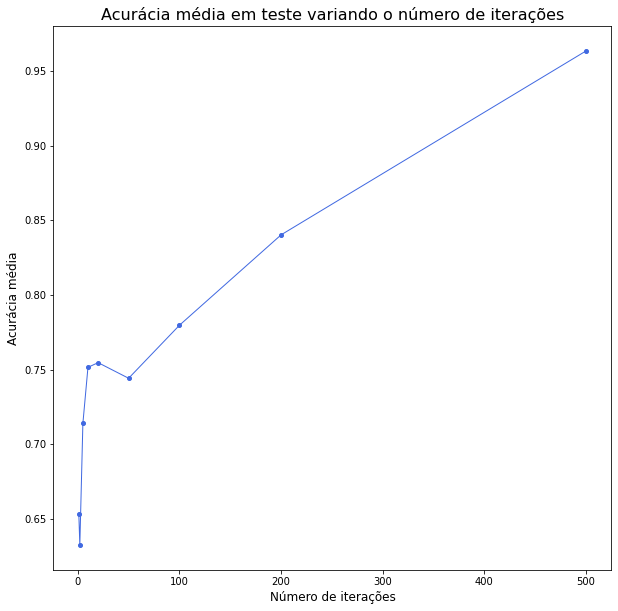

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot('num_iteracoes', 'acuracia_teste_media', data = df_acuracia, 
         marker = 'o', markerfacecolor = 'royalblue', markersize = 4, 
         color = 'royalblue', linewidth = 1)
plt.title('Acurácia média em teste variando o número de iterações', fontsize = 16)
plt.xlabel('Número de iterações', fontsize = 12)
plt.ylabel('Acurácia média', fontsize = 12)
axes = plt.gca()
plt.show()

Para o classificador Adaboost com 500 iterações (*decision stumps*), vamos reajustá-lo usando todos as observações no conjunto de dados para verificar mais detalhes desse classificador: 

In [14]:
# APROXIMADAMENTE 1 MINUTO E MEIO PARA EXECUTAR
clf = Adaboost(num_iteracoes = 500)
clf.ajuste(X = xdf.drop("resposta", axis = 1), y = xdf['resposta'], classe_positiva = 'positive')

A seguir fiz um gráfico dos valores das *decisions stumps*. Veja que as primeiras *decisions stumps* são as mais importantes para a decisão final do algoritmo e que grande parte das *decision stumps* possuem valores de $\alpha$ associados muito parecidos, em torno de 0,05;

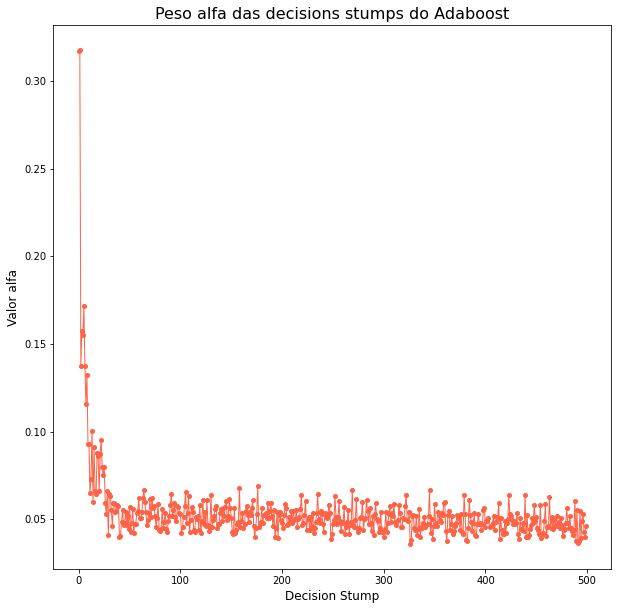

In [15]:
plt.figure(figsize = (10, 10))
plt.plot(clf.classificador['stumps']['alpha'], 
         marker = 'o', markerfacecolor = 'tomato', markersize = 4, 
         color = 'tomato', linewidth = 1)
plt.title('Peso alfa das decisions stumps do Adaboost', fontsize = 16)
plt.xlabel('Decision Stump', fontsize = 12)
plt.ylabel('Valor alfa', fontsize = 12)
axes = plt.gca()
plt.show()

Outro ponto de interesse é observar quais são as *decisions stumps* que mais apareceram durante a estimação do Adaboost. Essa informação está exibida a seguir. Veja que estimar vitória do jogador 'x' para todas as observações no conjunto de dados foi a *decision stump* que mais apareceu, porém ela é pouca informativa sob o problema do jogo. Das *decision stumps* que possuem alguma informação sob os jogos, note que naturalmente as ações do jogador 'x' são as que mais importam para levá-lo a vitória e que fazer jogadas em uma das diagonais do tabuleiro do jogo é importante (como era de se esperar) para levar a vitória do jogador 'x'.

In [16]:
df_resultados_stumps = clf.classificador['stumps'][['variavel', 'valor']]
df_resultados_stumps.loc[:, 'valor'] = [str(x) for x in (df_resultados_stumps['valor'])]
df_resultados_stumps.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


variavel  valor
True      None     121
meio.cen  x         30
sup.esq   x         30
sup.dir   x         29
inf.esq   x         29
inf.dir   x         29
meio.esq  x         27
meio.dir  x         27
inf.cen   x         27
sup.cen   x         26
meio.cen  b         16
sup.dir   b         15
inf.dir   b         15
sup.esq   b         14
inf.esq   b         14
meio.esq  b         13
inf.cen   b         13
meio.dir  b         13
sup.cen   b         12
dtype: int64

Abaixo está exibida a  descrição dos valores de erro das stumps e alpha ao longo das iterações. Note que por construção do problema a relação entre essas variáveis é óbvia, sabendo uma delas, facilmente chegamos a outra. Veja que pelo menos 75% das observações teve soma dos erros da stump dentro do intervalo (0,4726; 0,4826], ou seja, muitas stumps tiveram erros bem parecidos. Para os $\alpha's$ temos comportamento parecido, pelo menos 75% deles possuem valores entre (0,035; 0,055].

In [17]:
clf.classificador['stumps'].describe()

,erro_stump,alpha
count,500.000000,500.000000
mean,0.473374,0.053354
std,0.010653,0.021871
min,0.346222,0.035768
25%,0.472630,0.045557
50%,0.475092,0.049858
75%,0.477237,0.054795
max,0.482123,0.317844


Sumarização da média dos pesos das observações em cada uma das iterações. Se nota que uma das iterações teve peso médio igual a 0,004701 ao longo das iterações do algoritmo, esse valor é cerca de 4,50 vezes maior que a média da média dos pesos das observações que foi de 0,001044.

In [22]:
np.mean(clf.classificador['pesos'], axis = 1).describe()

count    958.000000
mean       0.001044
std        0.000640
min        0.000243
25%        0.000629
50%        0.000833
75%        0.001393
max        0.004701
dtype: float64

Observando quais foram as observações que obtiveram peso médio alto ao longo das iterações do algoritmo, vemos que as observações do final do conjunto de dados tiveram valores maiores de peso médio durante as iterações. Essas são observações em que as ações realizadas no jogo não levaram a vitória do jogador 'x', representando um fracasso no contexto do nosso problema.

In [21]:
pd.DataFrame(np.mean(clf.classificador['pesos'], axis = 1)).sort_values(by = 0, ascending = False)

,0
942,0.004701
950,0.004696
956,0.004695
954,0.004694
945,0.004678
...,...
227,0.000287
593,0.000286
136,0.000286
553,0.000286


Pesos da observação 942 ao longo das iterações. Note que a tendência desses erros é crescente ao longo das iterações, porém os pesos dessa observação não é estritamente crescente, pois em alguns momentos ele cai, mas logo volta a crescer novamente. Isso significa que o algoritmo teve dificuldades de acertar que esse jogo não levou a vitória do jogador 'x'. Nos momentos em que o peso da iteração $i+1$ foi menor que a iteração $i$, isso é sinal de que a *decision stump* escolhida na iteração $i$ acertou a previsão dessa observação.

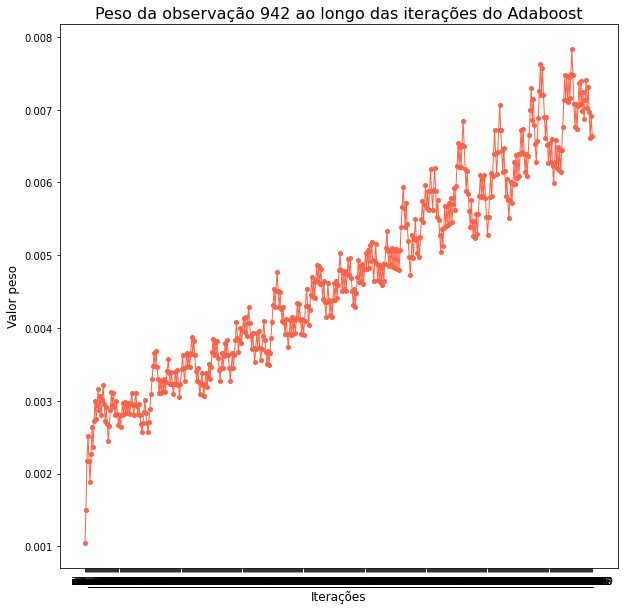

In [24]:
plt.figure(figsize = (10, 10))
plt.plot(clf.classificador['pesos'].iloc[942,:], 
         marker = 'o', markerfacecolor = 'tomato', markersize = 4, 
         color = 'tomato', linewidth = 1)
plt.title('Peso da observação 942 ao longo das iterações do Adaboost', fontsize = 16)
plt.xlabel('Iterações', fontsize = 12)
plt.ylabel('Valor peso', fontsize = 12)
axes = plt.gca()
plt.show()

# **Conclusão**

Nesse trabalho foi implementando o **algoritmo ensemble Adaboost** para tentar classificar corretamente o problema de classificação binária existente no jogo da velha. Chegamos a resultados bem sólidos. Com o algoritmo construindo 500 *decision stumps*(classificadores fracos), chegamos a acurácia esperada em novos dados de aproximadamente 96,3%. Acredito que a implementação do algoritmo ficou correta e bem executada e a documentação das funções, o que fazem e para que servem também ficou bem detalhada.